# Homework 4

**Gonçalo Meneses, 103401, e Tomás Arêde, 103239.**

Antes de começar, vamos remover os avisos que surgem ao longo deste notebook.

In [77]:
import warnings
warnings.filterwarnings('ignore')

Começamos por carregar o nosso ficheiro _arff_ e criar o data frame que irá armazenar os nossos dados.

In [78]:
from scipy.io import arff
import pandas as pd
import numpy as np

data, col_names = arff.loadarff('column_diagnosis.arff')
df = pd.DataFrame(data)
df['class'] = df['class'].str.decode('utf-8')
df.columns = col_names.names()

De seguida, procedemos à normalização das features do nosso dataset.

In [79]:
from sklearn.preprocessing import MinMaxScaler

X = df.drop('class', axis=1)
y = df['class']

scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

df_norm = pd.DataFrame(X_norm, columns=X.columns)
df_norm = pd.concat([df_norm, y], axis=1)
df_norm.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,0.355688,0.519900,0.229180,0.250857,0.307461,0.025148,Hernia
1,0.124501,0.296783,0.098578,0.144629,0.476649,0.036365,Hernia
2,0.411666,0.513932,0.322995,0.307661,0.386097,0.017523,Hernia
3,0.416151,0.557414,0.271260,0.289436,0.341826,0.051838,Hernia
4,0.227272,0.289479,0.128129,0.247022,0.409579,0.044173,Hernia


### Exercício 1

Purity and Silhouette scores for different values of k:
k=2: Purity=0.63226, Silhouette=0.36044
k=3: Purity=0.66774, Silhouette=0.29579
k=4: Purity=0.66129, Silhouette=0.27442
k=5: Purity=0.67742, Silhouette=0.23824


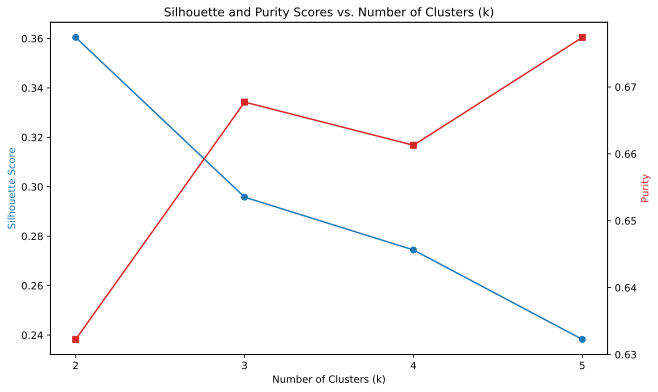

In [80]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import contingency_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

def purity_score(y_true, y_pred):
    confusion_matrix = contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix)

clustered_data = df_norm.copy()

silhouette_scores = []
purity_scores = []

k_values = range(2, 6)

for k in k_values:
    k_means = KMeans(n_clusters=k, random_state=0)
    k_means.fit(X_norm)
    
    cluster_labels = k_means.labels_
    clustered_data[f'Cluster_{k}'] = cluster_labels
    
    silhouette = silhouette_score(X_norm, cluster_labels)
    silhouette_scores.append(silhouette)

    purity = purity_score(y, cluster_labels)
    purity_scores.append(purity)

print("Purity and Silhouette scores for different values of k:")
for k, purity, silhouette in zip(k_values, purity_scores, silhouette_scores):
    print(f"k={k}: Purity={purity:.5f}, Silhouette={silhouette:.5f}")

plt.figure(figsize=(10, 6))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score', color='tab:blue')
plt.plot(k_values, silhouette_scores, marker='o', color='tab:blue', label='Silhouette Score')
plt.xticks(k_values)

plt.twinx()
plt.ylabel('Purity', color='tab:red')
plt.plot(k_values, purity_scores, marker='s', color='tab:red', label='Purity')

plt.title('Silhouette and Purity Scores vs. Number of Clusters (k)')

plt.show()

### Exercício 2

#### Exercício 2 (a)

In [81]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

explained_variance = pca.explained_variance_ratio_
print("Explained variabilities for the top two principal components:", explained_variance)

total_explained_variance = np.sum(explained_variance)
print(f"Total explained variability by the top two principal components: {total_explained_variance * 100:.5f}%")

Explained variabilities for the top two principal components: [0.56181445 0.20955953]
Total explained variability by the top two principal components: 77.13740%


#### Exercício 2 (b)

In [82]:
def sort_by_weight(weight, features):
    return sorted(zip(abs(weight), features), reverse=True)

component_1_loadings = pca.components_[0]
component_2_loadings = pca.components_[1]

print("Sorted input variables by absolute weight for the first principal component:")
for weight, variable in sort_by_weight(component_1_loadings, X.columns):
    print(f"{variable}: {weight:.5f}")

print("\nSorted input variables by absolute weight for the second principal component:")
for weight, variable in sort_by_weight(component_2_loadings, X.columns):
    print(f"{variable}: {weight:.5f}")

Sorted input variables by absolute weight for the first principal component:
pelvic_incidence: 0.59162
lumbar_lordosis_angle: 0.51508
pelvic_tilt: 0.46704
sacral_slope: 0.32569
degree_spondylolisthesis: 0.21693
pelvic_radius: 0.11582

Sorted input variables by absolute weight for the second principal component:
pelvic_tilt: 0.67037
pelvic_radius: 0.58107
sacral_slope: 0.44330
pelvic_incidence: 0.10004
lumbar_lordosis_angle: 0.08005
degree_spondylolisthesis: 0.00458


### Exercício 3

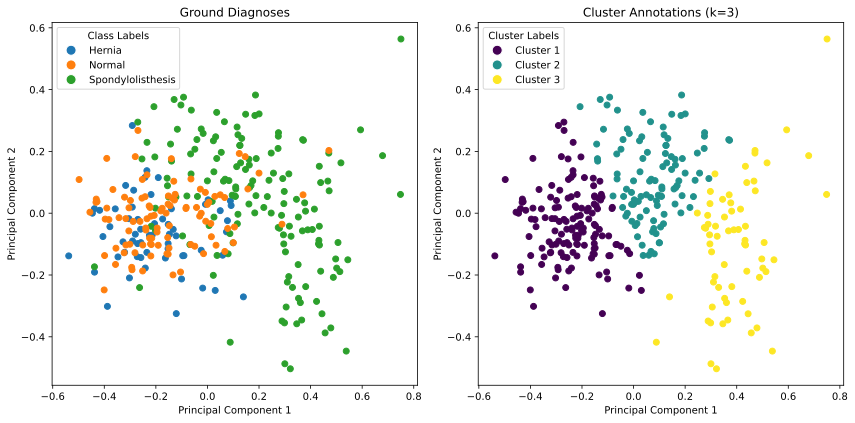

In [83]:
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

cmap = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap=cmap)
ax1.set_title('Ground Diagnoses')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')

scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=clustered_data['Cluster_3'], cmap='viridis')
ax2.set_title('Cluster Annotations (k=3)')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')

labels = label_encoder.classes_
handles1 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10, label=label) for i, label in enumerate(labels)]
ax1.legend(handles=handles1, title='Class Labels')

cluster_colors = ['#440154', '#21908C', '#FDE724']
custom_cmap = ListedColormap(cluster_colors)
handles2 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_cmap(i), markersize=10, label=f'Cluster {i + 1}') for i in range(3)]
ax2.legend(handles=handles2, title='Cluster Labels')

plt.tight_layout()
plt.show()

### Exercício 4

A técnica de aprendizagem por _clustering_ pode ser útil no diagnóstico de um indivíduo de duas formas distintas: criação de perfis de risco para avaliação da saúde e integração de informações clínicas adicionais.

No primeiro caso, mesmo quando observamos que dois grupos distintos de indivíduos podem ser agrupados no mesmo _cluster_, ainda é possível obter informações valiosas por meio do _clustering_. Por exemplo, se um novo indivíduo for atribuído ao segundo ou terceiro _cluster_, é provável que ele esteja em risco de desenvolver _Spondylolisthesis_. Porém, caso seja atribuído ao primeiro _cluster_ podemos inferir que a pessoa tem uma baixa probabilidade de ser diagnosticada com _Spondylolisthesis_ e, portanto, pode ser _Hernia_ ou _Normal_.

Relativamente ao nosso segundo ponto, um profissional de saúde poderá decidir o diagnóstico através da combinação deste resultado do _clustering_ com outras informações de diagnóstico ou características do indivíduo, como histórico médico, resultados de exames ou sintomas específicos. Assim, os prestadores de saúde poderão, então, fazer uma avaliação precisa do paciente, diagnosticando-o, finalmente, como _Hernia_ ou _Normal_.

Em resumo, o _clustering_ pode ser uma ferramenta valiosa para ajudar a avaliar se um indivíduo está doente ou não, fornecendo uma avaliação preliminar com base na associação a grupos de perfil de saúde semelhante, permitindo o aperfeiçoamento dessa avaliação com informações clínicas específicas do paciente.